# Parameters

In [1]:
subset_multiplier = 50   # increase the size of the subset by taking random composition of CCD
epoch = 60               # number of epochs for each AI
n = 1                    # number of loops for the genertic algorithm
K = 5                     # number of folds (= number of independant AI per generation)

train_on = "triplets"     # "triplets" or "blocks"
function = "square"       # "tan" or "square"
train_with = "parameters" # "parameters" or "points" TODO

train_prop = 0.7          # proportion of the dataset used for training

weights = [7.686424453317564,2.8124992994763316,0.448360122048755,4.727911837705288] # TODO

# Import libs

In [2]:
import os,sys, copy
import data_io
import utils.archive as archive
import numpy             as np
import matplotlib.pyplot as plt
import pandas            as pd
import tensorflow        as tf
from   IPython.display   import display
from   tensorflow        import keras
from   classes.block     import Block
from   classes.triplet   import Triplet
from   classes.shot      import Shot
from   classes.ccd       import CCD
from   classes.rate      import Rate
from scipy.optimize      import curve_fit

# Definition of the model

In [3]:
def get_model(Xt,Yt):
    # mse = tf.keras.losses.MeanSquaredError()
    model = keras.models.Sequential()
    model.add(keras.layers.Input((len(Xt[0]),), name="InputLayer"))
    model.add(keras.layers.Dense(64, activation='relu', name='Dense_n1'))
    model.add(keras.layers.Dense(64, activation='relu', name='Dense_n2'))
    model.add(keras.layers.Dense(64, activation='relu', name='Dense_n3'))
    model.add(keras.layers.Dense(len(Yt[0]), name='Output'))
    model.compile(optimizer = 'adam', loss = 'mse', metrics = ['accuracy'])
    return model

# Definition of efficiency functions

In [4]:
# tan
def ft(m,a,b,c,d):
    return a/4 * (1-np.tanh((m-b)/c)) * (1-np.tanh((m-b)/d))

# square
def fs(m,a,b,c,d):
    return (a-b*(m-21)**2) / (1+np.exp((m-c)/d))

# magnitude range
m = np.linspace(21,25.5,1000)

# Loading data and creating dataset

In [5]:
# Loading data
data_io.loadAll() # comment if already loaded to spare time

# Formating data in data set usable by the AI
if train_on == "triplets":
    data, outputs = data_io.get_ai_ready(items = Triplet.all, func=function,subsets_per_block=subset_multiplier, maxCCD=30)
elif train_on == "blocks":
    data, outputs = data_io.get_ai_ready(items = Block.all, func=function,subsets_per_block=subset_multiplier, maxCCD=30)
else:
    raise ValueError("train_on must be 'triplets' or 'blocks'")

print(len(data), "vectors containing", len(data[0])-outputs, "inputs and", outputs, "outputs")

# Normalization
mean = data[:,:-outputs].mean()
std  = data[:,:-outputs].std()
data[:,:-outputs] = (data[:,:-outputs] - mean) / std

Loading 2013AE.json
Loading 2013AO.json
Loading 2013BL.json
Loading 2014BH.json
Loading 2015AM.json
Loading 2015AP.json
Loading 2015BC.json
Loading 2015BD.json
Loading 2015BS.json
Loading 2015BT.json
8050 vectors containing 1440 inputs and 4 outputs


# Selecting a random test item

In [6]:
def get_test_item():
    if train_on == "blocks":
        test_item = np.array(list(Block.all.values()))[np.random.randint(0,len(Block.all)-1)]

    if train_on == "triplets":
        tripletList = []
        for rate in Rate.all:
            if type(rate.parent) == Triplet and rate.parent.id not in tripletList:
                tripletList.append(rate.parent.id)
        test_item = Triplet.all[tripletList[np.random.randint(0,len(tripletList)-1)]]

    print("Test item:",test_item.id)

    return test_item

test_item = get_test_item()

Test item: 15BC+1-2


# Prediction on test item

In [7]:
def item_data(test_item):
    data,outputs = test_item.to_ai_ready(func=function,maxCCD=30)

    X = data[:-outputs]
    Y = data[-outputs:]
    X = (X - mean) / std

    return X , Y

def predict(test_item, model):

    X, Y = item_data(test_item)

    X=np.array(X).reshape(1,len(X))

    prediction = model.predict(X)

    print(f"Prediction : {prediction[0]}")

    return prediction[0]

def plot_prediction(test_item, prediction, i = 0, n = 1, unique_title=True):

    X, Y = item_data(test_item)

    # Plotting the result
    f = ft if function == "tan" else fs

    plt.subplot(int(np.ceil(np.sqrt(n))),int(np.ceil(np.sqrt(n))),i+1)
    plt.plot(m, f(m,*prediction),         label="Machine Learning")
    plt.plot(m, f(m,Y[0],Y[1],Y[2],Y[3]), label="Excpected")
    plt.grid()

    if i == 0 or not unique_title: plt.title(f"Predition for {train_on} {test_item.id}")
    if i+1>n-np.ceil(np.sqrt(n)):  plt.xlabel("Magnitude")
    if i%np.ceil(np.sqrt(n))==0:   plt.ylabel("Efficiency")
    if i==0:                       plt.legend()

# Cenerating folds

In [8]:
def create_folds(K, data, train_prop, outputs):

    # Creating folds
    folds = []
    for j in range(K):
        folds.append(data[j::K])

    # Splitting data for training and test...
    Xt_list = []; Yt_list = []; Xv_list = []; Yv_list = []
    for j, fold in enumerate(folds):
        train_sets = int(len(fold)*train_prop)
        index = np.zeros(len(fold),dtype=bool)
        index[:train_sets] = True
        np.random.shuffle(index)

        data_train = fold[index]
        data_test  = fold[~index]

        Xt_list.append(data_train[:,:-outputs])
        Yt_list.append(data_train[:,-outputs:])
        Xv_list.append(data_test [:,:-outputs])
        Yv_list.append(data_test [:,-outputs:])

    if K > 1:
        # Composing training data using fold != j
        for j in range(K):
            Xt_list[j] = np.concatenate(np.array(Xt_list)[np.arange(len(Xt_list))!=j])
            Yt_list[j] = np.concatenate(np.array(Yt_list)[np.arange(len(Yt_list))!=j])

    return np.array(Xt_list), np.array(Yt_list), np.array(Xv_list), np.array(Yv_list)

# Training and validate

In [9]:
def train(model, Xt,Yt,Xv,Yv,epoch):
    h = model.fit(Xt, Yt, epochs = epoch, verbose = 0)        #, validation_data = (x_test[j], y_test[j])
    s = model.evaluate(Xv, Yv, verbose=0)
    return h,s

# Keeping only the best model

In [10]:
def get_best_model(generation, models, scores, lastScore, bestModel):
    minScore = lastScore
    output.write(f"{generation+1}, ")
    if minScore is None: minScore = scores[0][0]
    if bestModel is None: bestModel = models[0]
    average = 0
    for j,s in enumerate(scores):
        output.write(f"{s[0]}, ") 
        average += s[0]/K
        if s[0] < minScore:
            minScore = s[0]
            bestModel = models[j]
    output.write(f"{average}, {minScore}\n")
    return bestModel, minScore

# Training neural nework

🔁 Generation 1/1


C:\Users\vince\AppData\Local\Temp\ipykernel_22736\4032184431.py:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Xt_list[j] = np.concatenate(np.array(Xt_list)[np.arange(len(Xt_list))!=j])
C:\Users\vince\AppData\Local\Temp\ipykernel_22736\4032184431.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Yt_list[j] = np.concatenate(np.array(Yt_list)[np.arange(len(Yt_list))!=j])
C:\Users\vince\AppData\Local\Temp\ipykernel_22736\4032184431.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists

🏃‍♀️ Training model  with fold 5 as test...

🔮 Prediction...
1/1 [==============================] - 0s 80ms/step
Prediction : [8.7086886e-01 2.2446424e-02 2.4723940e+01 1.5527013e-01]


INFO:tensorflow:Assets written to: ./archives/2022-06-21_0f43222/1_M=50,N=1,K=5,E=60,F=square,T=triplets,Y=parameters,P=0.7/model.ckpt\assets


INFO:tensorflow:Assets written to: ./archives/2022-06-21_0f43222/1_M=50,N=1,K=5,E=60,F=square,T=triplets,Y=parameters,P=0.7/model.ckpt\assets


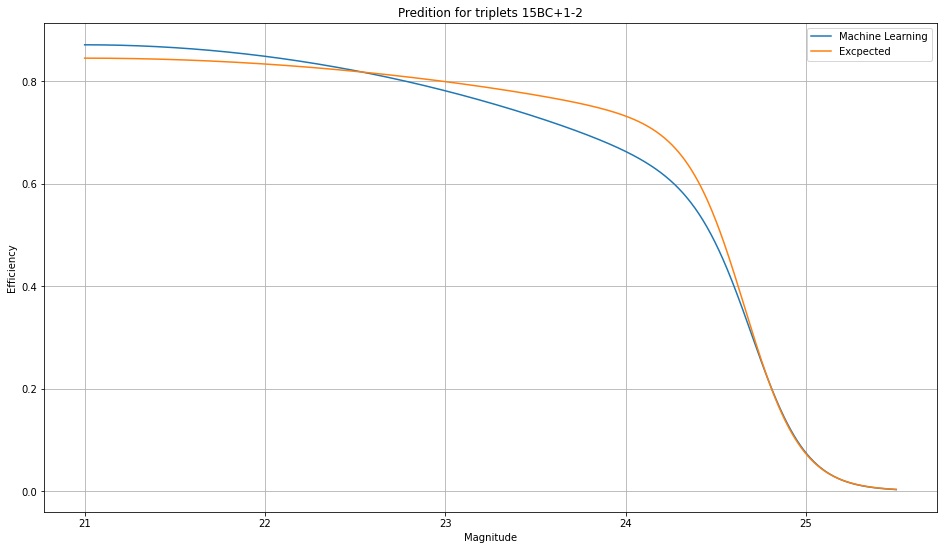

In [11]:
bestModel = None
bestScore = None
path = archive.new(name = archive.description(M = subset_multiplier, N = n, K = K, E = epoch, F = function, T = train_on, Y = train_with , P = train_prop))
output = open(f"{path}/ouput.csv","w")

output.write("Generation, ")
for j in np.arange(K): output.write(f"Score of model {j}, ")
output.write("Average, Score retained\n")

plt.figure(figsize=(16,9))

# Loop over generations (genetic algorithm)
for i in range(n):
  
  print(f"🔁 Generation {i+1}/{n}")

  np.random.shuffle(data)

  Xt_list, Yt_list, Xv_list, Yv_list = create_folds(K, data, train_prop, outputs)
  

  ################################################################################
  # Training K models independently

  models = []; history = []; scores = []
  for j in range(K):

    if K > 1:
      print(f"🏃‍♀️ Training model  with fold {j+1} as test...", end="\r")
      if j+1 == K: print(f"🏃‍♀️ Training model  with fold {j+1} as test...")

    # Sub sets for this fold

    Xt, Yt, Xv, Yv = Xt_list[j], Yt_list[j], Xv_list[j], Yv_list[j]

    # Getting new model if it's the first generation, and the old one if not

    if len(models) < j+1: models.append(get_model(Xt,Yt))
    else: models.append(copy.deepcopy(bestModel))

    model = models[j]


    # Training models

    res, score = train(model, Xt, Yt, Xv, Yv, epoch)
    history.append(res)
    scores.append(score)

  # Keeping the best one

  bestModel, bestScore = get_best_model(i,models, scores, bestScore, bestModel)

  # Making new prediction

  print("\n🔮 Prediction...")
  prediction = predict(test_item, bestModel)
  plot_prediction(test_item, prediction, i, n)

################################################################################
# Saving results

output.close()
model.save(f"{path}/model.ckpt")
plt.savefig(f"{path}/tno_efficiency_rate.png")
plt.show()

# New predictions

Test item: 13BL-1+0
1/1 [==============================] - 0s 20ms/step
Prediction : [8.7569851e-01 2.2070438e-02 2.4397312e+01 1.4136735e-01]
Test item: O+1+0
1/1 [==============================] - 0s 20ms/step
Prediction : [8.6015236e-01 2.3737222e-02 2.4460806e+01 1.4218429e-01]
Test item: E-1+0
1/1 [==============================] - 0s 17ms/step
Prediction : [9.0029192e-01 1.8191129e-02 2.3833097e+01 1.7479852e-01]
Test item: E-3+1
1/1 [==============================] - 0s 22ms/step
Prediction : [ 0.887023    0.0313082  24.157385    0.11218003]
Test item: O-3+1
1/1 [==============================] - 0s 18ms/step
Prediction : [ 9.2133451e-01 -6.8046749e-03  2.4573032e+01  1.1882118e-01]
Test item: 15AM+0+0
1/1 [==============================] - 0s 23ms/step
Prediction : [8.9657348e-01 1.4499217e-02 2.4759953e+01 1.5262845e-01]
Test item: 13BL+2+0
1/1 [==============================] - 0s 23ms/step
Prediction : [8.8171434e-01 1.8344671e-02 2.4276537e+01 1.3549164e-01]
Test item: 13BL

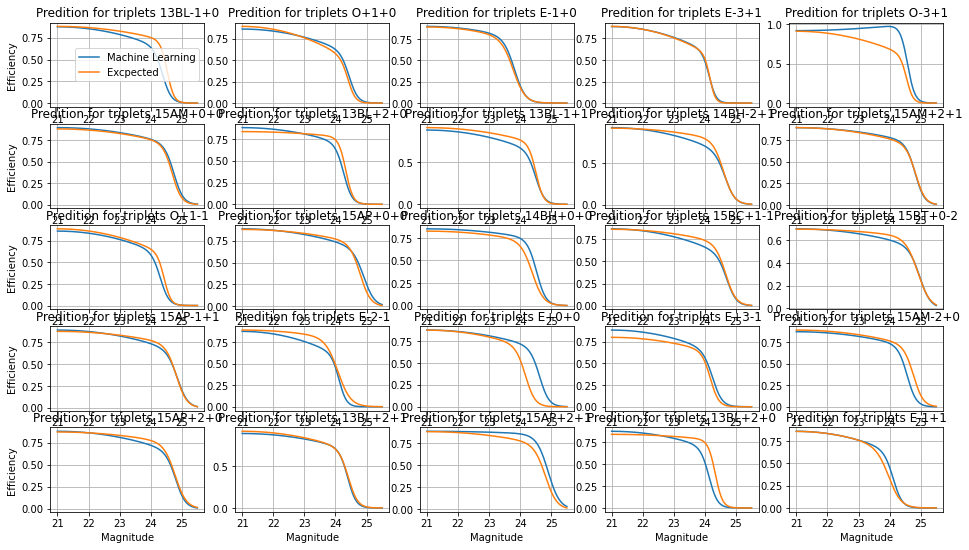

: 

In [12]:
plt.figure(figsize=(16,9))

N = 25
for i in range(N):
    test_item = get_test_item()
    prediction = predict(test_item, bestModel)
    plot_prediction(test_item, prediction, i, N, unique_title=False)

plt.savefig(f"{path}/prediction.png")
plt.show()